# Moon Cycles — Trading Debug Notebook

This notebook exists for one practical reason:

- In the main Moon notebook you can see **good base trading metrics** (using `pred_label` as a signal)
  but the **parameter sweep prints zeros** (`ret=0`, `UI=0`, `win=nan`).

That looks like a bug, but in most cases it is simply this:

- The sweep uses a **neutral-zone signal** built from `pred_proba_up` with thresholds like `0.55/0.45`.
- For Moon/ephemeris models (especially XGBoost), probabilities often live in a very tight band around `0.50`.
- If almost all probabilities are between `0.45` and `0.55`, then the neutral-zone signal becomes **all NaN** ("no signal").
- With "no signal" every day, the strategy never enters a position, so equity stays at 1.0 => **return = 0**.

So the goal here is to make that behavior *explicit* and *easy to diagnose*.

We will:
1. Load the same `best_runs` as in the main notebook (using cache).
2. For each model, print a clear summary of:
   - probability distribution
   - signal coverage (UP / DOWN / NaN)
   - number of trades
3. Run trading backtests in 3 modes:
   - **Always decide** (signal = `pred_label`)
   - **Fixed neutral zone** (for demonstration: shows why it can produce 0 trades)
   - **Validation-quantile neutral zone** (a safer way to create "no-signal" while still having trades)

Honesty note:
- We do **not** optimize trading parameters on the test set.
- If we choose thresholds, we choose them using **validation** statistics, then we apply them to test.

In [ ]:
# ------------------------------
# Imports and project path setup
# ------------------------------
#
# We keep this notebook self-contained.
# It can be run after the main Moon notebook finishes.
#
# Important: adding PROJECT_ROOT to sys.path allows us to import our local modules.

from pathlib import Path
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

PROJECT_ROOT = Path('/home/rut/ostrofun')
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from RESEARCH2.Moon_cycles.moon_data import (
    MoonLabelConfig,
    build_moon_phase_features,
    load_market_slice,
)
from RESEARCH2.Moon_cycles.ephemeris_data import (
    EphemerisFeatureConfig,
    build_ephemeris_feature_set,
)
from RESEARCH2.Moon_cycles.bakeoff_utils import run_moon_model_bakeoff

from RESEARCH2.Moon_cycles.eval_visuals import VisualizationConfig
from RESEARCH2.Moon_cycles.trading_utils import (
    TradingConfig,
    backtest_long_flat_signals,
    build_signal_from_proba,
    plot_backtest_price_and_equity,
    sweep_trading_params,
)

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 160)

In [ ]:
# ------------------------------
# Configuration (match the main notebook)
# ------------------------------
#
# If you want apples-to-apples results, keep these values the same as in
# `moon_cycles_deep_search_v2.ipynb`.

START_DATE = '2017-11-01'
END_DATE = None
USE_CACHE = True
VERBOSE = True

# Feature mode:
# - 'moon_only'     : strict Moon-only test
# - 'ephemeris_all' : maximum ephemeris information
FEATURE_SET = 'ephemeris_all'
CACHE_NAMESPACE = 'research2_moon' if FEATURE_SET == 'moon_only' else 'research2_ephem'

# Ephemeris config (used only when FEATURE_SET='ephemeris_all').
EPHEM_CFG = EphemerisFeatureConfig(
    coord_mode='both',
    orb_mult=0.25,
    include_pair_aspects=True,
    include_phases=True,
    add_trig_for_longitudes=True,
    add_trig_for_moon_phase=True,
    add_trig_for_elongations=True,
    exclude_bodies=(),
)

LABEL_CFG = MoonLabelConfig(
    horizon=1,
    move_share=0.5,
    label_mode='balanced_detrended',
    price_mode='raw',
)

# Gaussian grid (same as main notebook by default).
GAUSS_WINDOWS = [51, 101, 151, 201, 251, 301, 351, 401]
GAUSS_STDS = [10.0, 15.0, 20.0, 25.0, 30.0, 40.0, 50.0, 70.0, 90.0]

THRESHOLD_GAP_PENALTY = 0.25
THRESHOLD_PRIOR_PENALTY = 0.05

XGB_PARAMS = {
    'n_estimators': 500,
    'max_depth': 6,
    'learning_rate': 0.03,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'early_stopping_rounds': 50,
}

# Trading configuration.
FEE_RATE = 0.001  # 0.1% per buy and per sell
STOP_LOSSES = [0.0, 0.01, 0.02, 0.03, 0.05, 0.08]

# "Fixed" neutral zone (this is the one that often causes the "all zeros" sweep).
FIXED_UP_TH = 0.55
FIXED_DOWN_TH = 0.45

# Safer neutral zone idea (validation-quantile based):
# We will mark as signals only the extreme tails of validation probabilities.
# Example: q=0.20 means:
# - UP  if proba >= 80th percentile on validation
# - DOWN if proba <= 20th percentile on validation
# - else NaN (no signal)
VAL_QUANTILES = [0.10, 0.20, 0.30]

# Dark-theme visuals (same style as other research plots).
VIS_CFG = VisualizationConfig(
    rolling_window_days=90,
    rolling_min_periods=30,
    probability_bins=64,
)

print('Config loaded.')
print('FEATURE_SET      =', FEATURE_SET)
print('CACHE_NAMESPACE  =', CACHE_NAMESPACE)
print('Gaussian grid    =', len(GAUSS_WINDOWS) * len(GAUSS_STDS), 'combos')

Config loaded.
FEATURE_SET      = ephemeris_all
CACHE_NAMESPACE  = research2_ephem
Gaussian grid    = 72 combos


In [ ]:
# -------------------------------------------
# Load market data + build astro features (cached)
# -------------------------------------------
#
# We need these only because `run_moon_model_bakeoff()` builds labels from market prices
# and aligns them with the feature matrix.

df_market = load_market_slice(
    start_date=START_DATE,
    end_date=END_DATE,
    use_cache=USE_CACHE,
    verbose=VERBOSE,
)

if FEATURE_SET == 'moon_only':
    df_features = build_moon_phase_features(
        df_market=df_market,
        use_cache=USE_CACHE,
        verbose=VERBOSE,
        progress=True,
    )
else:
    df_features = build_ephemeris_feature_set(
        df_market=df_market,
        cfg=EPHEM_CFG,
        cache_namespace=CACHE_NAMESPACE,
        use_cache=USE_CACHE,
        verbose=VERBOSE,
        progress=True,
    )

print('Market rows :', len(df_market))
print('Feature rows:', len(df_features))
print('Feature cols:', len([c for c in df_features.columns if c != 'date']))
print('Market range:', df_market['date'].min().date(), '->', df_market['date'].max().date())

📂 Loading from cache: research2_moon__market__2017-11-01__8953c00f.parquet
📂 Loading from cache: research2_ephem__ephemeris_features__2017-11-01_both_orb0.25_phases__48f3de8f.parquet
Market rows : 3017
Feature rows: 3017
Feature cols: 1464
Market range: 2017-11-01 -> 2026-02-03


In [ ]:
# -------------------------------------------
# Load best model runs (mostly from cache)
# -------------------------------------------
#
# This is the same call as in the main notebook.
# If cache is warm, it should be mostly file loads.

bakeoff = run_moon_model_bakeoff(
    df_market=df_market,
    df_moon_features=df_features,
    gauss_windows=GAUSS_WINDOWS,
    gauss_stds=GAUSS_STDS,
    label_cfg=LABEL_CFG,
    include_xgb=True,
    xgb_params=XGB_PARAMS,
    threshold_gap_penalty=THRESHOLD_GAP_PENALTY,
    threshold_prior_penalty=THRESHOLD_PRIOR_PENALTY,
    cache_namespace=CACHE_NAMESPACE,
    use_cache=USE_CACHE,
    verbose=VERBOSE,
)

best_by_val = bakeoff['best_by_val_table']
best_runs = bakeoff['best_runs']

print('Best-by-validation table (one row per model):')
display(best_by_val)

📂 Loading from cache: research2_ephem__dataset__2017-11-01_h1_gw51__28ba1c35.parquet
📂 Loading from cache: research2_ephem__bakeoff_run__gw51__48da9e80.pkl
[1/288] left=287 bakeoff src=cached model=xgb gw=51 std=10.0 | val rmin=0.440 gap=0.129 mcc=0.009 acc=0.502 | test rmin=0.252 gap=0.532 mcc=0.043 acc=0.509 p=0.371 | BEST_TEST model=xgb gw=51 std=10.0 | val rmin=0.440 gap=0.129 mcc=0.009 acc=0.502 | test rmin=0.252 gap=0.532 mcc=0.043 acc=0.509 p=0.371
📂 Loading from cache: research2_ephem__bakeoff_run__gw51__fc6454ee.pkl
[2/288] left=286 bakeoff src=cached model=logreg gw=51 std=10.0 | val rmin=0.514 gap=0.012 mcc=0.039 acc=0.520 | test rmin=0.017 gap=0.969 mcc=0.013 acc=0.485 p=0.76 | BEST_TEST model=xgb gw=51 std=10.0 | val rmin=0.440 gap=0.129 mcc=0.009 acc=0.502 | test rmin=0.252 gap=0.532 mcc=0.043 acc=0.509 p=0.371
📂 Loading from cache: research2_ephem__bakeoff_run__gw51__e65c35f4.pkl
[3/288] left=285 bakeoff src=cached model=rf gw=51 std=10.0 | val rmin=0.427 gap=0.100 mcc=-

,model,threshold,val_score,val_acc,val_mcc,val_recall_min,val_recall_gap,test_acc,test_bal_acc,test_mcc,test_recall_min,test_recall_gap,p_value_vs_random,accuracy_ci95_low,accuracy_ci95_high,baseline_majority_test_acc,baseline_random_test_acc,test_up_share,pred_up_share,gauss_window,gauss_std
0,rf,0.48,0.459473,0.526549,0.059802,0.485597,0.088566,0.539823,0.540623,0.081825,0.480349,0.120548,0.049802,0.493731,0.585243,0.493363,0.471239,0.493363,0.559735,401,90.0
1,xgb,0.51,0.537654,0.539823,0.079528,0.539419,0.000865,0.522124,0.521723,0.044179,0.431111,0.181224,0.185754,0.476081,0.567794,0.497788,0.462389,0.497788,0.409292,201,40.0
2,mlp,0.05,0.495897,0.497788,-0.004435,0.497630,0.000295,0.493363,0.494185,-0.012527,0.308370,0.371630,0.628997,0.447522,0.539315,0.497788,0.462389,0.497788,0.685841,201,40.0
3,logreg,0.10,0.520746,0.526549,0.052704,0.523364,0.006047,0.488938,0.504017,0.035087,0.017167,0.973700,0.697536,0.443142,0.534921,0.484513,0.464602,0.484513,0.986726,151,20.0


In [ ]:
# -------------------------------------------
# Helper: print probability + signal coverage diagnostics
# -------------------------------------------
#
# The *main* debugging question we answer:
# - Do we actually have any UP/DOWN signals after applying a neutral zone?
# - Or is the model so uncertain that everything becomes NaN?

def describe_proba_and_signal(df: pd.DataFrame, proba_col: str, signal_col: str, title: str) -> None:
    """Print easy-to-read diagnostics for one probability column and one signal column."""

    p = pd.to_numeric(df[proba_col], errors='coerce')
    sig = pd.to_numeric(df[signal_col], errors='coerce')

    # Probability distribution summary.
    desc = p.describe(percentiles=[0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]).to_dict()

    # Signal coverage.
    n = len(sig)
    n_up = int((sig == 1).sum())
    n_down = int((sig == 0).sum())
    n_nan = int(sig.isna().sum())

    print() 
    print('-' * 100)
    print(title)
    print('Proba summary:', {k: float(v) for k, v in desc.items() if pd.notna(v)})
    print(
        f"Signal coverage: UP={n_up} ({n_up/max(n,1):.1%}), "
        f"DOWN={n_down} ({n_down/max(n,1):.1%}), "
        f"NO_SIGNAL(NaN)={n_nan} ({n_nan/max(n,1):.1%})"
    )

    if n_nan / max(n, 1) > 0.95:
        print('WARNING: >95% of days are NO_SIGNAL. This will usually create 0 trades and 0% return.')
        print('         Fix: use tighter thresholds (closer to 0.50) OR use validation-quantile thresholds.')


def build_neutral_signal_from_val_quantiles(
    pred_all_splits: pd.DataFrame,
    q_side: float,
    proba_col: str = 'pred_proba_up',
    out_col: str = 'trade_signal_neutral',
) -> tuple[pd.DataFrame, dict]:
    # Create a neutral-zone signal using probability quantiles.
    #
    # Honest intention:
    # - compute quantiles from VALIDATION probabilities,
    # - then apply thresholds to ALL rows (train/val/test).
    #
    # Why this notebook can fail here:
    # - In our cached bakeoff artifacts we usually store probabilities only for TEST rows.
    #   (Train/val proba can be NaN to keep caches smaller.)
    #
    # To keep the notebook usable for debugging:
    # - we TRY 'val' first
    # - if missing, we fall back to another split with enough probabilities and print a warning.
    #
    # IMPORTANT: if we do NOT use validation as the quantile source, results are NOT
    # suitable for final reporting. This is a debugging convenience only.

    df = pred_all_splits.copy()

    source_role = None
    p_source = None

    for role in ['val', 'train', 'test']:
        p = pd.to_numeric(df[df['split_role'] == role][proba_col], errors='coerce').dropna().to_numpy(dtype=float)
        if p.size >= 10:
            source_role = role
            p_source = p
            break

    if p_source is None or source_role is None:
        raise ValueError(
            'Not enough probabilities to compute quantiles on any split. '
            'This usually means pred_proba_up is empty/NaN everywhere.'
        )

    if source_role != 'val':
        print(            'WARNING: validation probabilities are missing in this artifact.'            f'         Using split_role=={source_role!r} to compute quantile thresholds.'
            '         OK for debugging, NOT honest for final test reporting.'
        )

    q_side = float(q_side)
    down_th = float(np.quantile(p_source, q_side))
    up_th = float(np.quantile(p_source, 1.0 - q_side))

    # Safety: if thresholds collapse (proba almost constant), fall back to 0.5/0.5.
    if not (down_th < up_th):
        down_th, up_th = 0.5, 0.5

    df[out_col] = build_signal_from_proba(
        df[proba_col].to_numpy(dtype=float),
        threshold_up=up_th,
        threshold_down=down_th,
    )

    return df, {'q_side': q_side, 'down_th': down_th, 'up_th': up_th, 'source_role': source_role}


MODEL: logreg
Always-decide trading metrics: {'final_equity': 0.9724192575397096, 'hold_final_equity': 0.9857308426386139, 'return_pct': -0.02758074246029041, 'hold_return_pct': -0.01426915736138612, 'excess_return_pct': -0.013504279792312945, 'num_trades': 5, 'winrate': 0.8, 'max_drawdown_pct': 39.29424842632304, 'ulcer_index': 15.502611925882908, 'exposure_pct': 98.45132743362832, 'ulcer_adjusted_return': -0.0017791029403401405}


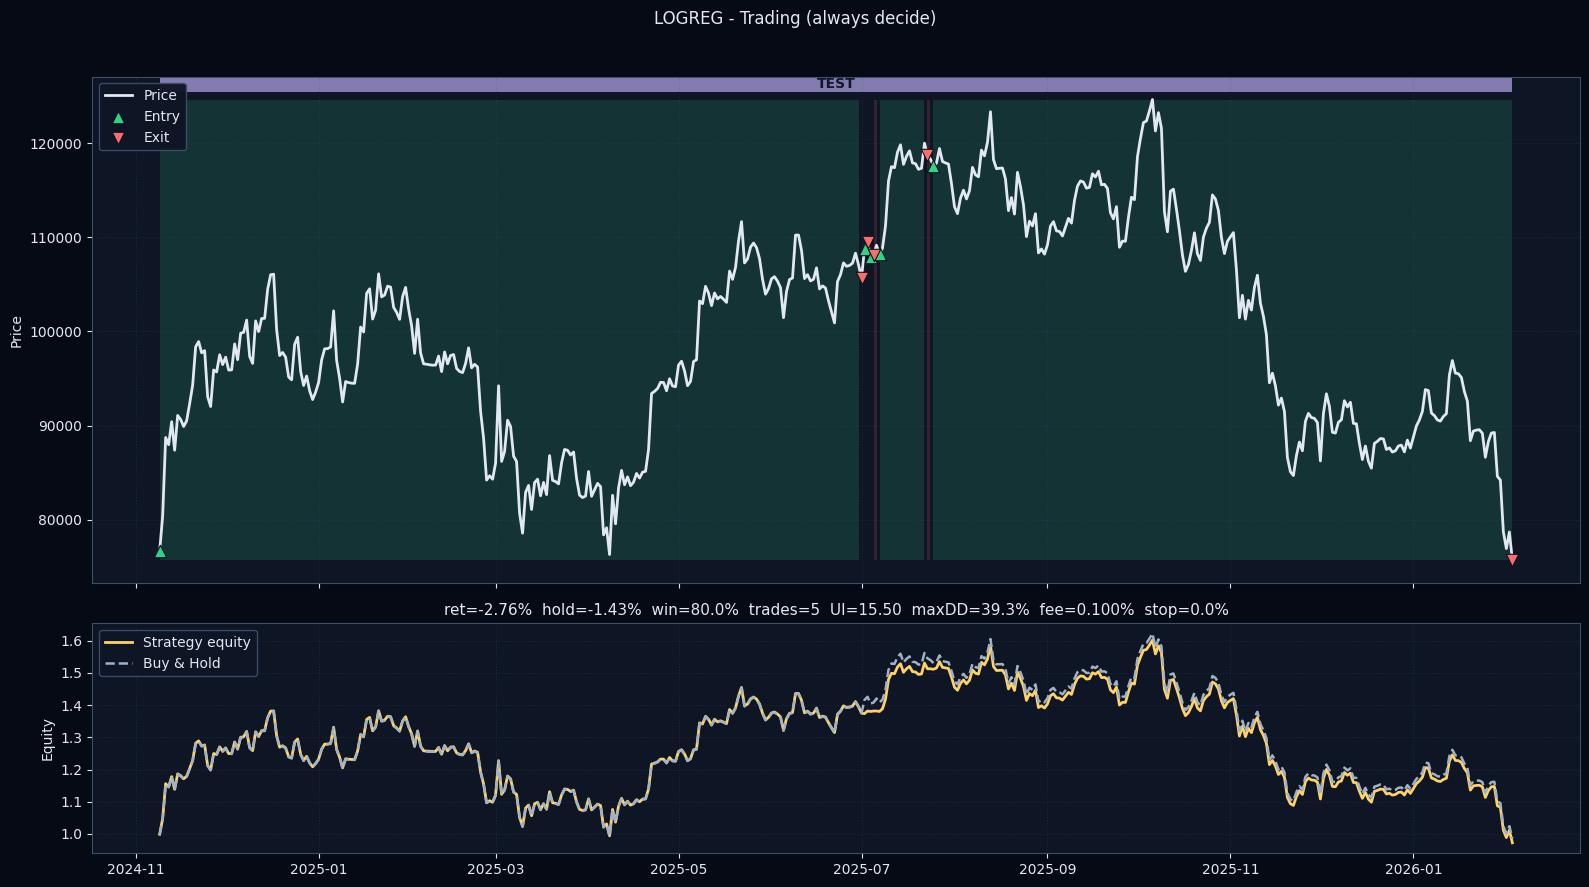

[sweep 1/6] left=5 stop=0.000 exit_no_sig=False | ret=-2.758% UI=15.50 trades=5 win=80.0% | BEST score=-0.00178
[sweep 2/6] left=4 stop=0.010 exit_no_sig=False | ret=1.683% UI=15.55 trades=18 win=22.2% | BEST score=0.00108
[sweep 3/6] left=3 stop=0.020 exit_no_sig=False | ret=-2.470% UI=16.08 trades=15 win=26.7% | BEST score=0.00108
[sweep 4/6] left=2 stop=0.030 exit_no_sig=False | ret=7.244% UI=13.81 trades=11 win=36.4% | BEST score=0.00525
[sweep 5/6] left=1 stop=0.050 exit_no_sig=False | ret=-4.532% UI=16.34 trades=10 win=40.0% | BEST score=0.00525
[sweep 6/6] left=0 stop=0.080 exit_no_sig=False | ret=-3.478% UI=15.07 trades=9 win=44.4% | BEST score=0.00525


,final_equity,hold_final_equity,return_pct,hold_return_pct,excess_return_pct,num_trades,winrate,max_drawdown_pct,ulcer_index,exposure_pct,ulcer_adjusted_return,stop_loss_pct,exit_on_no_signal
0,1.072445,0.985731,0.072445,-0.014269,0.087969,11,0.363636,32.956008,13.807246,97.123894,0.005247,0.03,False
1,1.016830,0.985731,0.016830,-0.014269,0.031549,18,0.222222,37.084359,15.546490,95.575221,0.001083,0.01,False
2,0.975304,0.985731,-0.024696,-0.014269,-0.010578,15,0.266667,38.747514,16.082584,96.238938,-0.001536,0.02,False
3,0.972419,0.985731,-0.027581,-0.014269,-0.013504,5,0.800000,39.294248,15.502612,98.451327,-0.001779,0.00,False
4,0.965220,0.985731,-0.034780,-0.014269,-0.020807,9,0.444444,39.743659,15.073734,97.566372,-0.002307,0.08,False
5,0.954685,0.985731,-0.045315,-0.014269,-0.031496,10,0.400000,39.770903,16.343954,97.345133,-0.002773,0.05,False



----------------------------------------------------------------------------------------------------
Fixed neutral-zone diagnostics (UP_TH=0.55, DOWN_TH=0.45)
Proba summary: {'count': 452.0, 'mean': 0.9034453380542601, 'std': 0.20466458642916535, 'min': 0.036776642402108956, '1%': 0.08731921857683074, '5%': 0.3798324623135891, '25%': 0.9281444917037803, '50%': 0.9994634067607064, '75%': 0.9999591195820955, '95%': 0.9999958071842449, '99%': 0.9999988873988798, 'max': 0.9999995624243864}
Signal coverage: UP=415 (91.8%), DOWN=31 (6.9%), NO_SIGNAL(NaN)=6 (1.3%)
[sweep 1/12] left=11 stop=0.000 exit_no_sig=False | ret=2.637% UI=15.48 trades=12 win=75.0% | BEST score=0.0017
[sweep 2/12] left=10 stop=0.000 exit_no_sig=True | ret=-4.364% UI=15.56 trades=15 win=66.7% | BEST score=0.0017
[sweep 3/12] left=9 stop=0.010 exit_no_sig=False | ret=-5.021% UI=16.12 trades=33 win=27.3% | BEST score=0.0017
[sweep 4/12] left=8 stop=0.010 exit_no_sig=True | ret=-4.779% UI=15.57 trades=37 win=29.7% | BEST s

,final_equity,hold_final_equity,return_pct,hold_return_pct,excess_return_pct,num_trades,winrate,max_drawdown_pct,ulcer_index,exposure_pct,ulcer_adjusted_return,stop_loss_pct,exit_on_no_signal
0,1.173897,0.985731,0.173897,-0.014269,0.190890,21,0.428571,32.956008,13.025034,90.265487,0.013351,0.03,False
1,1.134272,0.985731,0.134272,-0.014269,0.150691,25,0.440000,33.182542,13.135367,89.380531,0.010222,0.03,True
2,1.026371,0.985731,0.026371,-0.014269,0.041229,12,0.750000,39.294248,15.478856,92.477876,0.001704,0.00,False
3,1.000801,0.985731,0.000801,-0.014269,0.015288,23,0.478261,40.250016,15.978355,89.823009,0.000050,0.05,True
4,0.989803,0.985731,-0.010197,-0.014269,0.004131,20,0.450000,39.770903,16.350303,90.707965,-0.000624,0.05,False
5,0.973367,0.985731,-0.026633,-0.014269,-0.012543,18,0.500000,36.718089,14.926880,91.150442,-0.001784,0.08,False
6,0.956362,0.985731,-0.043638,-0.014269,-0.029794,15,0.666667,39.294248,15.559670,91.592920,-0.002805,0.00,True
7,0.954903,0.985731,-0.045097,-0.014269,-0.031275,27,0.333333,38.747514,15.906370,88.938053,-0.002835,0.02,False
8,0.959903,0.985731,-0.040097,-0.014269,-0.026201,21,0.476190,36.931911,13.913578,90.265487,-0.002882,0.08,True
9,0.952211,0.985731,-0.047789,-0.014269,-0.034005,37,0.297297,36.116935,15.567849,86.725664,-0.003070,0.01,True


ValueError: Not enough validation probabilities to compute quantiles.

In [ ]:
# -------------------------------------------
# Trading debug run
# -------------------------------------------
#
# We run this per model because different model families have different probability shapes.
# For example:
# - Some models can output very confident probabilities (close to 0 or 1).
# - XGBoost here often outputs probabilities extremely close to 0.50.
#   That does NOT mean it is useless, but it does mean "0.55/0.45 neutral zone" is too wide.

for model_name, run in best_runs.items():
    print('' + '=' * 120)
    print('MODEL:', model_name)

    pred = run['predictions'].copy()

    # We always slice TEST for performance reporting (honesty rule).
    test_df = pred[pred['split_role'] == 'test'].copy().reset_index(drop=True)
    test_df = test_df.dropna(subset=['close', 'pred_label', 'pred_proba_up'])

    # ------------------------------
    # A) Always-decide trading (signal = pred_label)
    # ------------------------------
    # This is the simplest possible translation from classification to trading:
    # - pred_label==1 => go long
    # - pred_label==0 => go flat
    test_df['trade_signal'] = test_df['pred_label'].astype(float)

    base_cfg = TradingConfig(
        fee_rate=FEE_RATE,
        stop_loss_pct=0.0,
        exit_on_no_signal=False,
        close_final_position=True,
        initial_cash=1.0,
    )

    base_run = backtest_long_flat_signals(test_df, signal_col='trade_signal', cfg=base_cfg)
    print('Always-decide trading metrics:', base_run['metrics'])
    plot_backtest_price_and_equity(base_run, title=f'{model_name.upper()} - Trading (always decide)', vis_cfg=VIS_CFG)

    # Quick stop-loss sweep on the always-decide signal.
    # This sweep should NEVER print "all zeros", because we always have signals.
    sweep_base = sweep_trading_params(
        df=test_df,
        signal_col='trade_signal',
        stop_losses=STOP_LOSSES,
        exit_on_no_signal_options=(False,),  # irrelevant when there is no NaN
        fee_rate=FEE_RATE,
        close_final_position=True,
        initial_cash=1.0,
        verbose=True,
    )
    display(sweep_base['results_table'].head(10))

    # ------------------------------
    # B) Fixed neutral-zone (often too wide)
    # ------------------------------
    # This block shows EXACTLY why the sweep can produce 0 trades.
    test_df['trade_signal_fixed_neutral'] = build_signal_from_proba(
        test_df['pred_proba_up'].to_numpy(dtype=float),
        threshold_up=FIXED_UP_TH,
        threshold_down=FIXED_DOWN_TH,
    )

    describe_proba_and_signal(
        df=test_df,
        proba_col='pred_proba_up',
        signal_col='trade_signal_fixed_neutral',
        title=f'Fixed neutral-zone diagnostics (UP_TH={FIXED_UP_TH}, DOWN_TH={FIXED_DOWN_TH})',
    )

    sweep_fixed = sweep_trading_params(
        df=test_df,
        signal_col='trade_signal_fixed_neutral',
        stop_losses=STOP_LOSSES,
        exit_on_no_signal_options=(False, True),
        fee_rate=FEE_RATE,
        close_final_position=True,
        initial_cash=1.0,
        verbose=True,
    )
    display(sweep_fixed['results_table'].head(10))

    # ------------------------------
    # C) Validation-quantile neutral-zone (more robust)
    # ------------------------------
    # Here we compute thresholds from validation distribution, then apply them to test.
    # This keeps the "no-signal" idea but avoids the "0 trades" trap.

    for q_side in VAL_QUANTILES:
        pred_with_sig, th = build_neutral_signal_from_val_quantiles(
            pred_all_splits=pred,
            q_side=float(q_side),
            proba_col='pred_proba_up',
            out_col=f'trade_signal_valq_{q_side:.2f}',
        )

        test_df_q = pred_with_sig[pred_with_sig['split_role'] == 'test'].copy().reset_index(drop=True)
        test_df_q = test_df_q.dropna(subset=['close', 'pred_proba_up'])

        describe_proba_and_signal(
            df=test_df_q,
            proba_col='pred_proba_up',
            signal_col=f'trade_signal_valq_{q_side:.2f}',
            title=(
                f"Val-quantile neutral-zone q_side={q_side:.2f} "
                f"(DOWN_TH={th['down_th']:.4f}, UP_TH={th['up_th']:.4f})"
            ),
        )

        sweep_q = sweep_trading_params(
            df=test_df_q,
            signal_col=f'trade_signal_valq_{q_side:.2f}',
            stop_losses=STOP_LOSSES,
            exit_on_no_signal_options=(False, True),
            fee_rate=FEE_RATE,
            close_final_position=True,
            initial_cash=1.0,
            verbose=True,
        )

        # Show only top-5 to keep output readable.
        display(sweep_q['results_table'].head(5))

        if sweep_q['best_run'] is not None:
            plot_backtest_price_and_equity(
                sweep_q['best_run'],
                title=(
                    f"{model_name.upper()} - Trading (val-quantile neutral, q_side={q_side:.2f}) "
                    f"best by ulcer-adjusted return"
                ),
                vis_cfg=VIS_CFG,
            )